In [1]:
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(DEXSeq)
library(DESeq2)
library(dplyr)
library(ggplot2)

Loading required package: BiocParallel
Loading required package: Biobase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matr

In [3]:
%%R
# Set up the working directory
data_dir <- "/beegfs/scratch/ric.broccoli/ric.broccoli/PW_RNA_seq_deep"
working_dir <- "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
setwd(working_dir)

In [4]:
%%R

# Local Functions
compare_file_structures <- function(file_list) {
  results <- lapply(file_list, function(file_path) {
    n_lines <- length(readLines(file_path))
    file_size <- file.info(file_path)$size
    list(
      file = basename(file_path),
      n_lines = n_lines,
      size_mb = file_size / 1024 / 1024,
      avg_line_size = if (n_lines > 0) file_size / n_lines else 0
    )
  })
  do.call(rbind, results) %>% as.data.frame()
}

parse_dexseq_id <- function(feature_id) {
  if (startsWith(feature_id, "*")) {
    return(list(gene_id = feature_id, exon_num = NA))
  }
  tryCatch({
    parts <- strsplit(feature_id, ":")[[1]]
    gene_id <- parts[1]
    exon_num <- gsub('"', '', parts[2])
    list(gene_id = gene_id, exon_num = exon_num)
  }, error = function(e) {
    list(gene_id = feature_id, exon_num = NA)
  })
}

examine_dexseq_file <- function(file_path, n_head = 5, n_random = 5, n_tail = 5) {
  cat("\nExamining file:", basename(file_path), "\n")
  
  # Peek at raw file contents
  cat("\nFirst few lines (raw):\n")
  system(paste("head -n 5", file_path))
  
  # Read the file
  df <- tryCatch({
    read.table(file_path, sep = "\t", header = FALSE, 
               col.names = c("feature_id", "exon_number", "count"), stringsAsFactors = FALSE)
  }, error = function(e) {
    cat("Error reading file:", conditionMessage(e), "\n")
    return(NULL)
  })
  
  if (is.null(df)) return(NULL)
  
  # Process feature_id
  parsed_ids <- lapply(df$feature_id, parse_dexseq_id)
  df$gene_id <- sapply(parsed_ids, `[[`, "gene_id")
  
  # File information
  cat("\nFile size:", file.info(file_path)$size / 1024, "KB\n")
  cat("Number of lines:", nrow(df), "\n")
  
  # Basic DataFrame information
  cat("\nDataFrame Info:\n")
  str(df)
  
  # Print column names
  cat("\nColumn names:\n")
  print(colnames(df))
  
  # Show first few lines
  cat("\nFirst", n_head, "lines:\n")
  print(head(df, n_head))
  
  # Basic statistics for counts
  cat("\nCount statistics:\n")
  print(summary(df$count))
  
  # Additional information
  cat("\nNumber of unique genes:", length(unique(df$gene_id)), "\n")
  cat("\nTop 5 genes by total counts:\n")
  gene_counts <- aggregate(count ~ gene_id, data = df, sum)
  print(head(gene_counts[order(-gene_counts$count), ], 5))
  
  # Check for potential issues
  cat("\nChecking for potential issues:\n")
  issues <- character()
  if (any(is.na(df$count))) issues <- c(issues, "- Contains missing values in counts")
  if (any(df$count < 0)) issues <- c(issues, "- Contains negative counts")
  if (!is.numeric(df$count)) issues <- c(issues, "- Counts are not numeric")
  if (!is.character(df$feature_id)) issues <- c(issues, paste("- Feature ID column is not string type (current type:", class(df$feature_id), ")"))
  
  # Check for special entries
  special_entries <- df[startsWith(df$feature_id, "*"), ]
  if (nrow(special_entries) > 0) {
    cat("\nSpecial entries found:\n")
    print(special_entries)
  }
  
  if (length(issues) > 0) {
    cat("\nIssues found:\n")
    cat(paste(issues, collapse = "\n"), "\n")
  } else {
    cat("No major issues found\n")
  }
  
  return(df)
}

examine_genes_of_interest <- function(df, genes) {
  cat("\nExamining genes of interest:\n")
  for (gene in genes) {
    gene_data <- df[grepl(gene, df$gene_id, fixed = TRUE), ]
    if (nrow(gene_data) > 0) {
      cat("\n", gene, ":\n")
      cat("Number of exons:", nrow(gene_data), "\n")
      cat("Total counts:", sum(gene_data$count), "\n")
      cat("Mean counts per exon:", mean(gene_data$count), "\n")
      cat("\nExon-level data:\n")
      print(gene_data[order(gene_data$exon_number), ])
      
      # Create plot for this gene
      p <- ggplot(gene_data, aes(x = seq_along(count), y = count)) +
        geom_bar(stat = "identity") +
        ggtitle(paste('Exon counts for', gene)) +
        xlab('Exon number') +
        ylab('Counts') +
        theme_minimal()
      
      ggsave(paste0('exon_counts_', gene, '.pdf'), p, width = 10, height = 4)
    }
  }
}

prepare_sample_table <- function(sample_info) {
  samples_subset <- sample_info[sample_info$condition %in% c('EDO', 'ND1'), ]
  samples_subset$condition <- factor(samples_subset$condition)
  samples_subset$replicate <- factor(samples_subset$replicate)
  rownames(samples_subset) <- NULL
  samples_subset
}

create_dexseq_object <- function(sample_table) {
  formula <- ~ sample + exon + condition:exon
  reduced_formula <- ~ sample + exon
  
  dxd <- DEXSeqDataSetFromHTSeq(
    countfiles = sample_table$count_file,
    sampleData = sample_table,
    design = formula,
    flattenedfile = NULL
  )
  
  dxd
}

run_dexseq_analysis <- function(dxd) {
  dxd <- estimateSizeFactors(dxd)
  dxd <- estimateDispersions(dxd)
  dxd <- testForDEU(dxd)
  dxd <- estimateExonFoldChanges(dxd)
  dxd
}

extract_results <- function(dxd) {
  res <- DEXSeqResults(dxd)
  results_df <- as.data.frame(res)
  results_df$significant <- results_df$padj < 0.05
  results_df
}

filter_significant_results <- function(results_df) {
  significant_results <- results_df[
    results_df$padj < 0.05 & 
    results_df$log2fold_EDO_ND1 != 0,
  ]
  significant_results[order(significant_results$padj), ]
}


In [5]:
%%R
# DEXSeq Files

# Load Files
dexseq_dir <- file.path(working_dir, "DexSeq_counts")
count_files <- list.files(dexseq_dir, pattern = "\\.formatted\\.counts$", full.names = TRUE)


In [6]:
%%R
# Create sample information
sample_info <- data.frame(
  sample = sub("\\.formatted\\.counts$", "", basename(count_files)),
  condition = ifelse(startsWith(basename(count_files), "EDO"), "EDO",
                     ifelse(startsWith(basename(count_files), "ND1"), "ND1",
                            ifelse(startsWith(basename(count_files), "PW1"), "PW1", "Unknown"))),
  replicate = sub(".*_(\\d+)\\.formatted\\.counts$", "\\1", basename(count_files)),
  count_file = count_files,
  stringsAsFactors = FALSE
)

In [7]:
%%R
# Filter for EDO and ND1 samples (excluding PW1)
edo_nd1_samples <- sample_info[sample_info$condition %in% c('EDO', 'ND1'), ]
edo_nd1_samples$condition <- factor(edo_nd1_samples$condition)
edo_nd1_samples$replicate <- factor(edo_nd1_samples$replicate)
rownames(edo_nd1_samples) <- NULL

In [8]:
%%R
# Examine Files
cat("Comparing file structures:\n")
structure_comparison <- compare_file_structures(edo_nd1_samples$count_file)
print(structure_comparison)


Comparing file structures:
          file n_lines      size_mb avg_line_size
1 EDO_1.fo....  393424 9.531430....  25.40370....
2 EDO_2.fo....  393424 9.539485....  25.42517....
3 EDO_3.fo....  393424 9.502113....  25.32557....
4 ND1_1.fo....  393424 9.528618....  25.39621....
5 ND1_2.fo....  393424 9.534873....  25.41288....
6 ND1_3.fo....  393424 9.515054....  25.36006....


In [9]:
%%R
# Examine first file in detail
first_file <- edo_nd1_samples$count_file[1]
df <- examine_dexseq_file(first_file)


Examining file: EDO_1.formatted.counts 

First few lines (raw):
ENSG00000000003.14	001	107
ENSG00000000003.14	002	900
ENSG00000000003.14	003	340
ENSG00000000003.14	004	1
ENSG00000000003.14	005	278

File size: 9760.185 KB
Number of lines: 393424 

DataFrame Info:
'data.frame':	393424 obs. of  4 variables:
 $ feature_id : chr  "ENSG00000000003.14" "ENSG00000000003.14" "ENSG00000000003.14" "ENSG00000000003.14" ...
 $ exon_number: chr  "001" "002" "003" "004" ...
 $ count      : int  107 900 340 1 278 246 262 196 342 233 ...
 $ gene_id    : chr  "ENSG00000000003.14" "ENSG00000000003.14" "ENSG00000000003.14" "ENSG00000000003.14" ...

Column names:
[1] "feature_id"  "exon_number" "count"       "gene_id"    

First 5 lines:
          feature_id exon_number count            gene_id
1 ENSG00000000003.14         001   107 ENSG00000000003.14
2 ENSG00000000003.14         002   900 ENSG00000000003.14
3 ENSG00000000003.14         003   340 ENSG00000000003.14
4 ENSG00000000003.14         004     1 E

In [10]:
%%R
head(df)

          feature_id exon_number count            gene_id
1 ENSG00000000003.14         001   107 ENSG00000000003.14
2 ENSG00000000003.14         002   900 ENSG00000000003.14
3 ENSG00000000003.14         003   340 ENSG00000000003.14
4 ENSG00000000003.14         004     1 ENSG00000000003.14
5 ENSG00000000003.14         005   278 ENSG00000000003.14
6 ENSG00000000003.14         006   246 ENSG00000000003.14


[1] 107 900 340   1 278 246


In addition: Warning messages:
1: Removed 2974 rows containing non-finite outside the scale range (`stat_bin()`). 
2: Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`). 


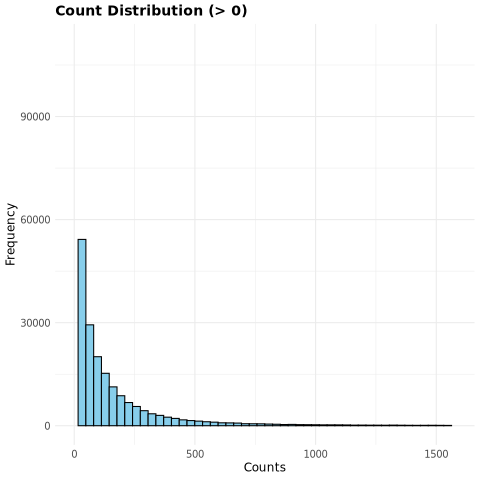

In [16]:
%%R
# Plot overall count distribution
counts <- df$count[df$count > 0]
print(head(counts))

# Create the plot
plt <- ggplot(data.frame(counts = counts), aes(x = counts)) +
  geom_histogram(bins = 50, fill = 'skyblue', color = 'black') +
  scale_x_continuous(limits = c(0, quantile(counts, 0.99))) +
  labs(title = 'Count Distribution (> 0)',
       x = 'Counts',
       y = 'Frequency') +
  theme_minimal() +
  theme(plot.title = element_text(size = 14, face = "bold"),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

# Add density line
# plt <- plt + geom_density(aes(y = after_stat(count)), color = 'red', linewidth = 1)

# Print the plot
print(plt)

In [17]:
%%R
# Print outliers
outliers <- df[df$count > quantile(counts, 0.99), ]
cat("\nOutliers (counts above 99th percentile):\n")
print(head(outliers[, c('feature_id', 'count', 'gene_id')]))


Outliers (counts above 99th percentile):
             feature_id count            gene_id
292  ENSG00000001629.10  2470 ENSG00000001629.10
293  ENSG00000001630.17  2886 ENSG00000001630.17
294  ENSG00000001630.17  2385 ENSG00000001630.17
1417 ENSG00000005108.16  3069 ENSG00000005108.16
1605 ENSG00000005249.13  6085 ENSG00000005249.13
1883 ENSG00000005483.21  1856 ENSG00000005483.21


In [25]:
%%R
# DEXSeq Analysis
create_dexseq_dataset <- function(sample_info, formatted_files) {
  tryCatch({
    sample_data <- sample_info[, c('sample', 'condition')]
    sample_data$sample <- as.character(sample_data$sample)
    sample_data$condition <- as.character(sample_data$condition)
    
    ordered_files <- sample_info$count_file
    
    cat("\nSample data for DEXSeq:\n")
    print(sample_data)
    
    cat("\nOrdered count files:\n")
    for (i in seq_along(sample_data$sample)) {
      cat(sample_data$sample[i], ": ", ordered_files[i], "\n")
    }
    
    gff_file <- "gencode.v31.basic.annotation.DEXSeq.gff"
    if (!file.exists(gff_file)) {
      cat("GFF file not found:", gff_file, "\n")
    } else {
      cat("GFF file exists:", gff_file, "\n")
      cat(readLines(gff_file, n = 5), sep = "\n")
    }
    
   dxd <- DEXSeqDataSetFromHTSeq(
    countfiles = ordered_files,
    sampleData = sample_data,
    design = ~ condition,
    flattenedfile = gff_file
    )
    
    return(dxd)
    
  }, error = function(e) {
    cat("Error creating DEXSeqDataSet:", conditionMessage(e), "\n")
    stop(e)
  })
}

In [26]:
%%R
dxd <- create_dexseq_dataset(sample_info, count_files)


Sample data for DEXSeq:
  sample condition
1  EDO_1       EDO
2  EDO_2       EDO
3  EDO_3       EDO
4  ND1_1       ND1
5  ND1_2       ND1
6  ND1_3       ND1
7  PW1_1       PW1
8  PW1_2       PW1
9  PW1_3       PW1

Ordered count files:
EDO_1 :  /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_1.formatted.counts 
EDO_2 :  /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_2.formatted.counts 
EDO_3 :  /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/EDO_3.formatted.counts 
ND1_1 :  /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_1.formatted.counts 
ND1_2 :  /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_2.formatted.counts 
ND1_3 :  /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/ND1_3.formatted.counts 
PW1_1 :  /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DexSeq_counts/PW1_1.formatted.counts 
PW1_2 :  /beegfs/scratch/ric.broccoli/kubacki.mic

RInterpreterError: Failed to parse and evaluate line 'dxd <- create_dexseq_dataset(sample_info, count_files)\n'.
R error message: 'Error in FUN(X[[i]], ...) : subscript out of bounds'